## Importing Packages and Source Code

In [1]:
import json
import os
import sys
## biom used to view Qiime Artifacts
import biom
%matplotlib inline 

In [2]:
## Import Source Code
from src.data import make_dataset
from src.features import build_features
from src.models import make_models

In [3]:
## Creating paths to store temp and out data
if not os.path.exists("data/temp"):
    os.makedirs("data/temp")
if not os.path.exists("data/out"):
    os.makedirs("data/out")

In [4]:
## Used to format graph
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

## Reading Data

In [5]:
## Obtaining file paths
with open("config/data-params.json") as fh:
    file_paths = json.load(fh)

In [6]:
feature_table = make_dataset.read_feature_table(file_paths["feature_table_path"])
metadata = make_dataset.read_metadata(file_paths["metadata_path"])

/Users/amando/Desktop/DSC180-Q2-Project/src/data/make_dataset.py:27: DtypeWarning: Columns (1,2,3,4,6,7,8,10,11,12,13,14,17,18,19,20,25,26,27,29,30,31,32,33,34,35,36,37,38,40,41,42,43,44,45,46,55,56,57,61,62,63,64,65,66,67,69,70,71,72,73,75,76,78,80,82,83,84,85,86,87,88,89,90,91,92,95,98,99,102,103,104,105,106,107,108,109,111,119,121,122,123,124,125,126,127,128,129,130,131,132,133,134,136,138,139,141,142,143,144,145,146,147,148,152,153,155,156,157,160,164,165,168,169,170,172,173,174,175) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(path, sep='\t', index_col=0)


In [7]:
biom_table = feature_table.view(biom.Table)
print(biom_table.head())

# Constructed from biom file
#OTU ID	11666.BLANK7.7B	11666.BLANK5.5B	11666.G0341A	11666.BLANK3.3A	11666.BLANK5.5E
AACATAAGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGTAGGTGGTCTGTTAAGTCAGATGTGAAATGTAAGGGCTCAACCCTTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0
AACATAGGGGGCAAGCGTTGCCCGGAATCACTGGGCGTAAAGGGCGCGTAGGTGGTCTGTTAAGTCAGATGTGAAATGTAAGGGCTCAACCCTTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0
AACATAGGGGGCAAGCGTTGTCCGGAAACACTGGGCGTAAAGGGCGCGTAGGCGGTCTGTTAAGTCGGATGTGAAATGTAAGGGCTCAACCCTTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCATAAAGGGCGCGTAGGTGGTTTGTTAAGTCAGATGTGAAATGTAGGGGCTCAACCCCTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGAGCGCGTAGGTGGTCTGTTAAGTCAGATGTGAAATGTAAGGGCTCAACCCTTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0


In [8]:
metadata.head()

,abdominal_obesity_idf_v2,abdominal_obesity_ncep_v2,ac_ratio_gt30,ac_ratio_gt30_v2,age_units,age_v2,agegroup_c6_nhanes_v2,agegroup_c6_v2,anonymized_name,antibiotic,...,taxon_id,title,type_stool,us_born_v2,weight_norm_overall_v2,weight_units,yes_no,yogurt,yrs_btwn_viv2,yrsus_c2_v2
sample_name,,,,,,,,,,,,,,,,,,,,,
11666.BLANK1.1A,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,BLANK1.1A,not applicable,...,256318.0,GOLD study,not applicable,not applicable,not applicable,not applicable,NaN,not applicable,not applicable,not applicable
11666.BLANK1.1A.ITS,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,BLANK1.1A.ITS,not applicable,...,256318.0,GOLD study,not applicable,not applicable,not applicable,not applicable,NaN,not applicable,not applicable,not applicable
11666.BLANK1.1B,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,BLANK1.1B,not applicable,...,256318.0,GOLD study,not applicable,not applicable,not applicable,not applicable,NaN,not applicable,not applicable,not applicable
11666.BLANK1.1B.ITS,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,BLANK1.1B.ITS,not applicable,...,256318.0,GOLD study,not applicable,not applicable,not applicable,not applicable,NaN,not applicable,not applicable,not applicable
11666.BLANK1.1C,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,BLANK1.1C,not applicable,...,256318.0,GOLD study,not applicable,not applicable,not applicable,not applicable,NaN,not applicable,not applicable,not applicable


# Create Features

In [9]:
## Obtaining file paths
with open("config/feature-params.json") as fh:
    feature_params = json.load(fh)

In [10]:
organized_metadata = build_features.organize_metadata(metadata, **feature_params)

In [11]:
organized_metadata[0]

,abdominal_obesity_ncep_v2,ckd_v2,diabetes2_v2,hypertension2_v2,precvd_v2,elevated_bp_selfmeds_v2,gender_v2,agegroup_c6_v2,bmigrp_c6_v2,center,us_born_v2,income_c5_v2
sample_name,,,,,,,,,,,,
11666.G0001A,1.0,0.0,0.0,1.0,0.0,1.0,F,4.0,4.0,M,0.0,1.0
11666.G0001L,1.0,0.0,0.0,1.0,0.0,1.0,F,4.0,4.0,M,0.0,1.0
11666.G0003A,1.0,0.0,0.0,0.0,0.0,0.0,F,4.0,3.0,B,1.0,4.0
11666.G0003L,1.0,0.0,0.0,0.0,0.0,0.0,F,4.0,3.0,B,1.0,4.0
11666.G0004A,0.0,1.0,0.0,1.0,0.0,1.0,M,5.0,3.0,B,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11666.G1777A,0.0,1.0,0.0,1.0,0.0,1.0,M,3.0,3.0,C,1.0,4.0
11666.G1778A,1.0,1.0,0.0,1.0,1.0,1.0,F,6.0,3.0,S,0.0,3.0
11666.G1779A,1.0,0.0,1.0,1.0,0.0,1.0,F,5.0,3.0,S,0.0,2.0


In [12]:
organized_metadata[1]

,abdominal_obesity_ncep_v2,ckd_v2,diabetes2_v2,hypertension2_v2,precvd_v2,elevated_bp_selfmeds_v2,gender_v2,agegroup_c6_v2,bmigrp_c6_v2,center,us_born_v2,income_c5_v2
sample_name,,,,,,,,,,,,
11666.G0001A,T,F,F,T,F,T,F,4.0,4.0,M,0.0,1.0
11666.G0001L,T,F,F,T,F,T,F,4.0,4.0,M,0.0,1.0
11666.G0003A,T,F,F,F,F,F,F,4.0,3.0,B,1.0,4.0
11666.G0003L,T,F,F,F,F,F,F,4.0,3.0,B,1.0,4.0
11666.G0004A,F,T,F,T,F,T,M,5.0,3.0,B,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11666.G1777A,F,T,F,T,F,T,M,3.0,3.0,C,1.0,4.0
11666.G1778A,T,T,F,T,T,T,F,6.0,3.0,S,0.0,3.0
11666.G1779A,T,F,T,T,F,T,F,5.0,3.0,S,0.0,2.0


# Model Building

In [13]:
## Obtaining model params
with open("config/model-params.json") as fh:
    model_params = json.load(fh)

In [14]:
# need to return updated metadata path
qiime_metadata_tf = make_dataset.read_qiime_metadata("data/temp/final_metadata_disease_tf.tsv")
qiime_metadata_tf

Metadata
--------
2938 IDs x 12 columns
abdominal_obesity_ncep_v2: ColumnProperties(type='categorical', missing_scheme='blank')
ckd_v2:                    ColumnProperties(type='categorical', missing_scheme='blank')
diabetes2_v2:              ColumnProperties(type='categorical', missing_scheme='blank')
hypertension2_v2:          ColumnProperties(type='categorical', missing_scheme='blank')
precvd_v2:                 ColumnProperties(type='categorical', missing_scheme='blank')
elevated_bp_selfmeds_v2:   ColumnProperties(type='categorical', missing_scheme='blank')
gender_v2:                 ColumnProperties(type='categorical', missing_scheme='blank')
agegroup_c6_v2:            ColumnProperties(type='numeric', missing_scheme='blank')
bmigrp_c6_v2:              ColumnProperties(type='numeric', missing_scheme='blank')
center:                    ColumnProperties(type='categorical', missing_scheme='blank')
us_born_v2:                ColumnProperties(type='numeric', missing_scheme='blank')
inco

/Users/amando/opt/anaconda3/envs/qiime2-2022.8/lib/python3.8/site-packages/seaborn/matrix.py:1210: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


Results (name = value)
-------------------------------------------------------------------------------------------------------------
sample_estimator   = <artifact: SampleEstimator[Classifier] uuid: 9f77b4d6-6fb3-4474-ab0e-2569989eb8f6>
feature_importance = <artifact: FeatureData[Importance] uuid: c18cf54b-0144-4a3b-8786-6c6e32130c48>
predictions        = <artifact: SampleData[ClassifierPredictions] uuid: c2ef5eaa-2ce6-4f0e-8738-8740286359ea>
model_summary      = <visualization: Visualization uuid: e010f718-1493-4ae4-af80-35f6f438eb3c>
accuracy_results   = <visualization: Visualization uuid: 3320468c-1f9b-4715-b37b-c68699c49134>
probabilities      = <artifact: SampleData[Probabilities] uuid: 80de6b03-8014-476e-944b-c8264df524f6>
heatmap            = <visualization: Visualization uuid: a7471ff4-b3bf-4a61-a5a9-24835296c79e>
training_targets   = <artifact: SampleData[TrueTargets] uuid: cb385013-6d20-439e-b54d-f733c3c7fd7f>
test_targets       = <artifact: SampleData[TrueTargets] uuid: 46fc

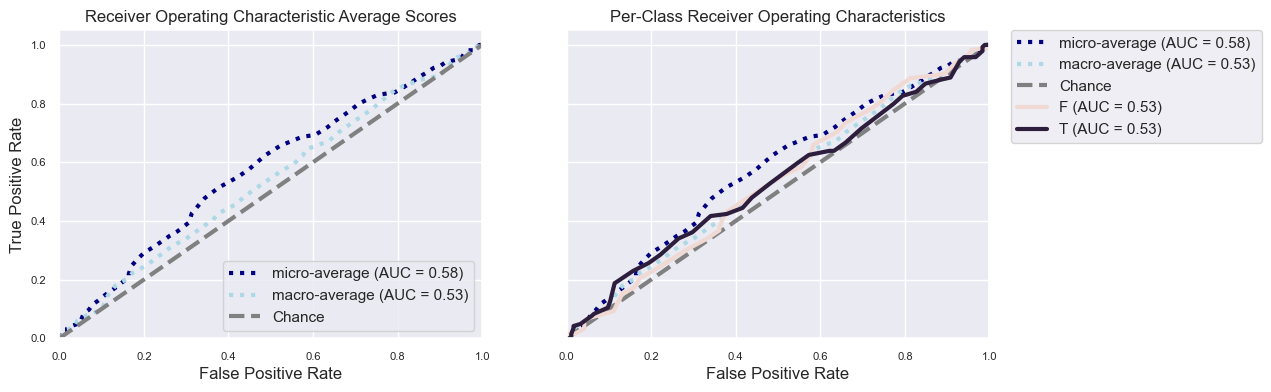

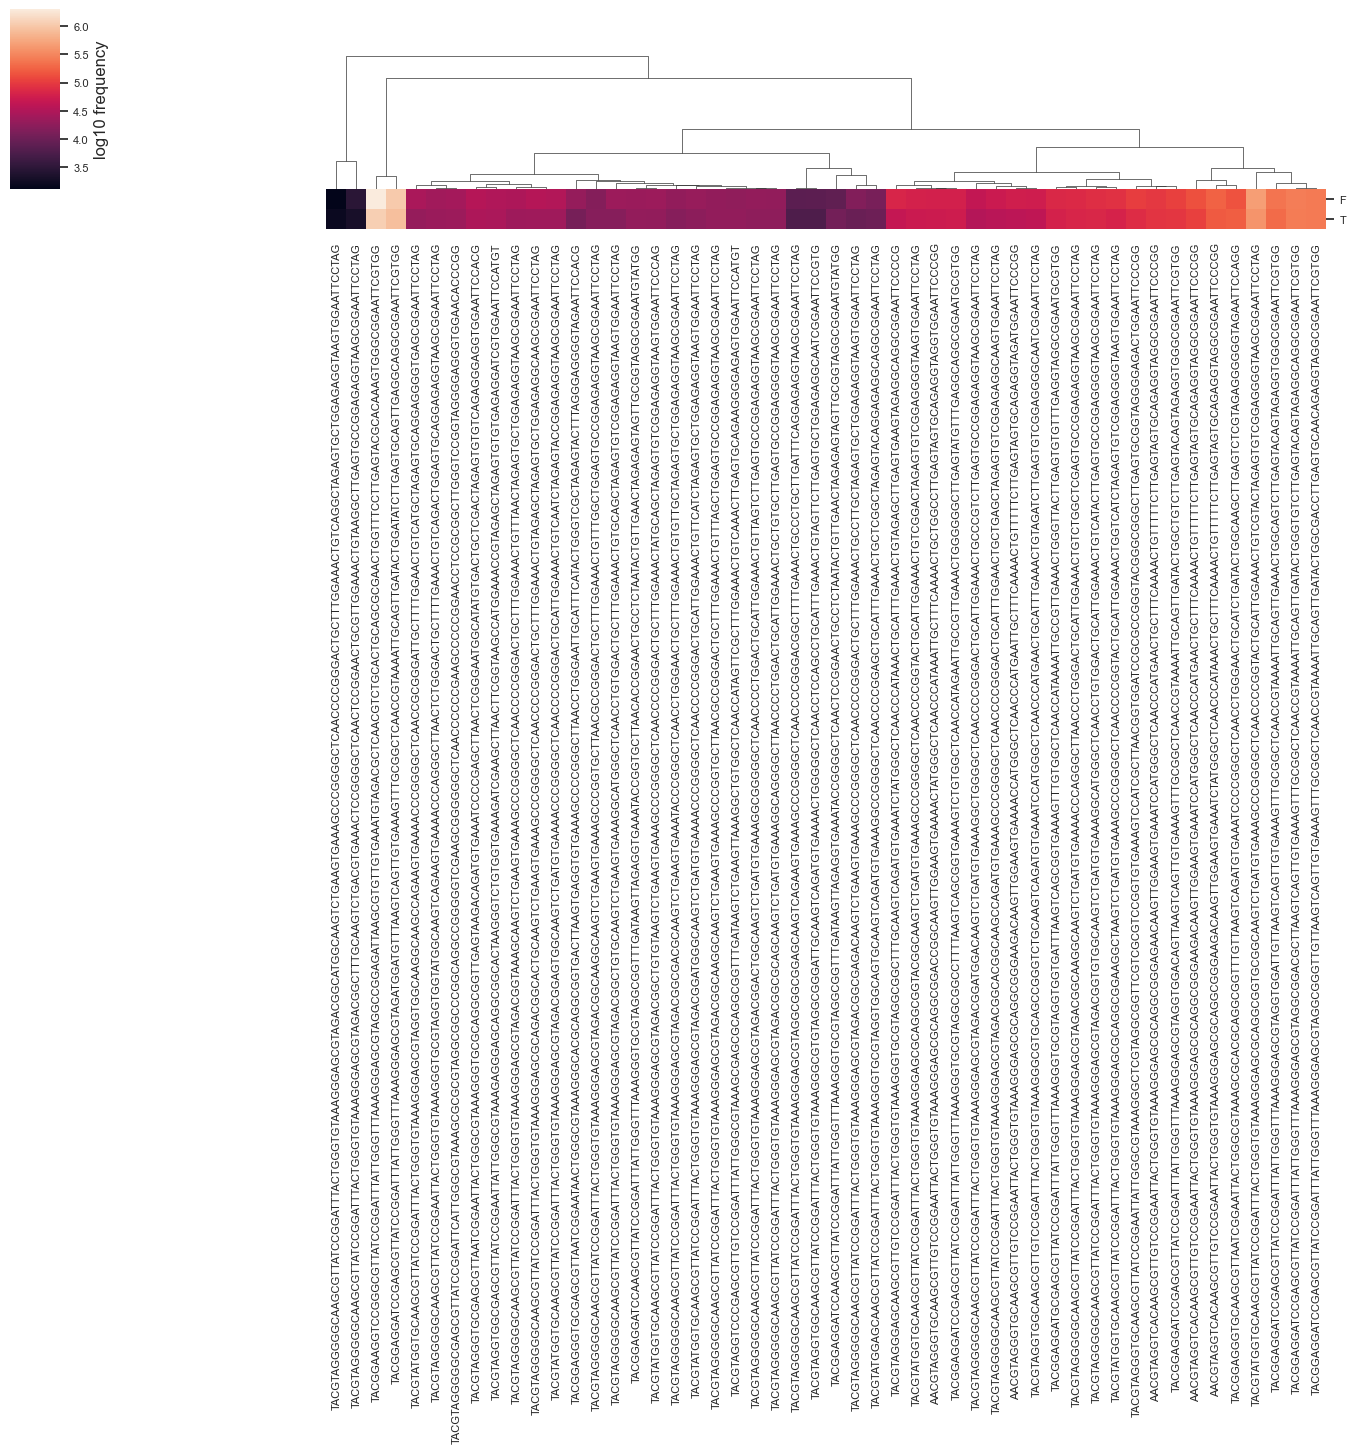

In [18]:
ckd_v2_model = make_models.sample_classifier_single_disease(feature_table, qiime_metadata_tf.get_column('ckd_v2'))
ckd_v2_model